In [52]:
import sys
sys.path.append('/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/eth-capstone-treewater-deficit/src')
# sys.path.append('/workspaces/eth-capstone-treewater-deficit/src')
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import  r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras as tf_keras

from sklearn.preprocessing import StandardScaler
from treewater.utils import *

In this notebook we set 7 day horizon and to be included in the model

In [51]:
import importlib
import treewater.utils as utils
importlib.reload(utils)

# check presence
print(hasattr(utils, "build_autoregressive_training_data_fast_LSTM_scheduled"))
print(hasattr(utils, "cross_validation_LSTM_Horizon"))
print(hasattr(utils, "build_ds_from_get_dataset_LSTM"))

True
True
True


In [34]:
# set global random seed
seed = 66666
tf.random.set_seed(
    seed
)

In [35]:
# # At top of notebook
# %load_ext autoreload
# %autoreload 2

# from treewater.utils import *

In [36]:
derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"
# data_dir = "/workspaces/eth-capstone-treewater-deficit/data/tstoy04"
# derived_path = "/workspaces/eth-capstone-treewater-deficit/data"

In [37]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [38]:
df_series_all.head(5)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01


## data preparation

In [39]:
# test if in the same day same site, temp and other features are the same

sites = df_series_all['site_name'].unique()
for site in sites:
    df_site = df_series_all.loc[df_series_all.site_name == site, ]
    series = df_site.series_no.unique()
    if len(series) >=2:
        series_1 = df_site.loc[df_site.series_no == series[0], ]
        series_2 = df_site.loc[df_site.series_no == series[1], ]
        merged = pd.merge(series_1, series_2, on='ts', suffixes=('_1', '_2'))
        temp_equal = all(merged['at_1'] == merged['at_2'])
        pr_equal = all(merged['pr_1'] == merged['pr_2'])
        dp_equal = all(merged['dp_1'] == merged['dp_2'])
        sr_equal = all(merged['sr_1'] == merged['sr_2'])
        if not (temp_equal and pr_equal and dp_equal and sr_equal):
            print(f"Data mismatch found in site {site} between series {series[0]} and {series[1]}")

# so far they are no mismatch found, all the other measurements are the same for different series in the same site


In [40]:
# twd_tree_series_sites

In [41]:
# Psudotsuga mnzisii", from site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', "mch_easting",
                                                                        "mch_northing"]].drop_duplicates(), on=['site_name', 'species'], how='left')

In [42]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded, hmm maybe not yet
df_series_all_features = df_series_all_median
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['year'])

In [43]:
# create a dataframe with log2 transformed twd values
df_series_features_log2 = df_series_features.copy()
epsilon = 1
df_series_features_log2['twd'] = np.log2(epsilon+ df_series_features_log2['twd'])

(array([8368., 2837., 2769., 2630., 2114., 1456.,  740.,  628.,  271.,
         107.]),
 array([0.        , 0.27301828, 0.54603655, 0.81905483, 1.0920731 ,
        1.36509138, 1.63810966, 1.91112793, 2.18414621, 2.45716448,
        2.73018276]),
 <BarContainer object of 10 artists>)

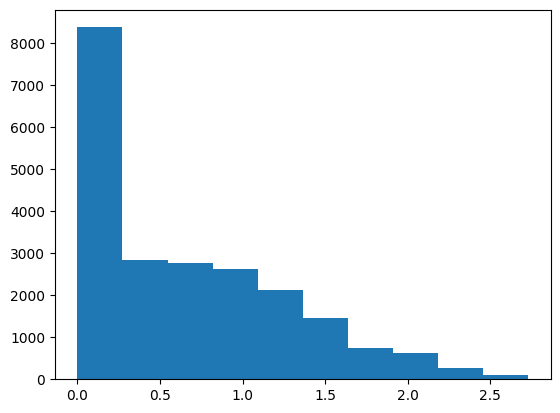

In [44]:
plt.hist(df_series_features_log2['twd'])

split the data into training and test set
 - train and test set split by an even distribution of sites? 
 - easting and northing recommended
 - if autoregressive with lag =13
    - label: twd_t
    - input feature: [twd_t-12, twd_t-11, ...twd_t-1, at_t-1, lt_t-1]? 
    - can i use at_t as input feature?


Normalize certain colums: 

- pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude
- if twd was treated as feature should we then standardize it when model is autoregressive? 
- should we normalize it before or after splitting by windows? - i guess really no harm either way 

In [45]:
# Configure features
config = FeatureConfig()
lag_n =7 # use 7 and smaller model size 
label_window_size = 7

# Autoregressive
# Split data
train_df_at, val_df_at, test_df_at = create_training_test_set_optimized(
    df_series_features_log2,
    feature_window_size=lag_n, # optional
    autoregressive=True
)

train_df_at, val_df_at, test_df_at = standardize_dataset(
    train_df_at, val_df_at, test_df_at,
    config
)

# Create windows
train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at,  train_y_at = get_dataset_LSTM(
    train_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)

val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at, val_y_at = get_dataset_LSTM(
    val_df_at,
    feature_window_size=lag_n,
    label_window_size = label_window_size,
    autoregressive=True,
    shift = 1,
    config=config
)





### build LSTM
- LSTM 
- RNN
- and perhaps try elastic net to improve ridgeregression model performance, and try gaussian regressor

In [46]:

batch_size = 128
lag_n = 7
label_window_size = 7

### Autoregressive
- reduce hidden space size to prevent overfitting

In [47]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(
    train_df_at, n_splits=4, feature_window_size=lag_n,  config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        label_window_size = label_window_size,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        label_window_size = label_window_size,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    

In [48]:
idx = tf.range(7, dtype=tf.float32)
weights = tf.exp(-0.1*idx)
weights = weights / tf.reduce_sum(weights)
weights

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([0.18903418, 0.1710452 , 0.1547681 , 0.14003997, 0.1267134 ,
       0.11465503, 0.10374416], dtype=float32)>

In [53]:
# defined weighted MAE loss function with weight decay exponentially
# def index_weighted_mae_exp(H, decay=0.1):
#     idx = tf.range(H, dtype=tf.float32)
#     weights = tf.exp(-decay * idx)
#     weights = weights / tf.reduce_sum(weights)  # ✅ normalize

#     def loss(y_true, y_pred):
#         abs_err = tf.abs(y_true - y_pred)        # (B, H)
#         return tf.reduce_sum(abs_err * weights)

#     return loss

def index_weighted_mae_exp(H, decay=0.2):
    idx = tf.range(H, dtype=tf.float32)
    weights = tf.exp(-decay * idx)
    weights = weights / tf.reduce_sum(weights)

    def loss(y_true, y_pred):
        abs_err = tf.abs(y_true - y_pred)            # (B, H)
        per_sample = tf.reduce_sum(abs_err * weights, axis=-1)  # (B,)
        return tf.reduce_mean(per_sample)            # scalar
    return loss # do batch mean after summing over horizon



# dynamic input
def build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X, train_static_X_ts, lag_n, label_window_size, hidden_unit = 16):
     # we don't actually need the input features but rather the shape information
    timesteps = lag_n
    n_features = train_X_ts_at.shape[2] # include TWD + other variables

    dyn_in = tf_keras.layers.Input(shape=(timesteps, n_features), name="past_dynamic")
    x_dyn = tf_keras.layers.LSTM(hidden_unit, return_sequences=False)(dyn_in)
    x_dyn = tf_keras.layers.Dense(hidden_unit, activation="relu")(x_dyn)

    # current day other features
    n_static = train_day_feat_X.shape[1]
    static_in = tf_keras.Input(shape=(n_static,), name="current_day_exog")
    x_static = tf_keras.layers.Dense(4, 
                                     activation="relu",
                                     kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                     )(static_in)

    # static input
    n_current = train_static_X_ts.shape[1]
    curr_in = tf_keras.Input(shape=(n_current,), name="static")
    x_curr = tf_keras.layers.Dense(4, 
                                   activation="relu",
                                   kernel_regularizer=tf.keras.regularizers.l2(1e-3),
                                   )(curr_in)


    combined = tf_keras.layers.Concatenate()([x_dyn, x_static, x_curr])
    x = tf_keras.layers.Dense(16, activation="relu")(combined)
    out = tf_keras.layers.Dense(label_window_size, activation = "linear")(x)


    model_at = tf_keras.Model(
    inputs=[dyn_in, static_in, curr_in],
    outputs=out,
    )

    model_at.compile(
        optimizer=tf_keras.optimizers.Adam(learning_rate=1e-4*5),
        loss= index_weighted_mae_exp(label_window_size, decay=0.3),
        metrics=[
        tf_keras.metrics.RootMeanSquaredError(name="rmse"),
        tf_keras.metrics.MeanAbsoluteError(name="mae"),
    ],
    )
    return model_at

In [54]:
# building datasets
batch_size = batch_size

train_ds_at = tf.data.Dataset.from_tensor_slices((
    (train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at),
    train_y_at,
))
train_ds_at = (
    train_ds_at
    .shuffle(buffer_size=len(train_X_ts_at))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds_at = tf.data.Dataset.from_tensor_slices((
    (val_X_ts_at, val_day_feat_X_at, val_static_X_ts_at),
    val_y_at,
))
val_ds_at = (
    val_ds_at
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)


# create cross validate datasets tensorflow datasets

train_val_datasets_at = cross_validate_datasets(train_df_at, n_splits=4, feature_window_size=lag_n, config=config)

# build tf.data.Dataset for each fold
cv_train_val_ds_at = []
for train_cv_df_at, val_cv_df_at in train_val_datasets_at:
    
    train_cv_ds_at = build_ds_from_get_dataset_LSTM(
        train_cv_df_at ,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        shift=1,
        batch_size=batch_size,
    )
    val_cv_ds_at = build_ds_from_get_dataset_LSTM(
        val_cv_df_at,
        feature_window_size=lag_n,
        config=config,
        autoregressive=True,
        label_window_size = label_window_size,
        shift=1,
        batch_size=batch_size,
    )
    cv_train_val_ds_at.append((train_cv_ds_at, val_cv_ds_at))

    



In [ ]:
# create two models with different hidden units 

model_fold1 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n, label_window_size = label_window_size, hidden_unit = 16)
losses_cv_horizon, maes_cv_horizon, rmses_cv_horizon_mean, rmses_cv_horizons, r2s_cv_horizons,  y_preds_cv_horizon, y_trues_cv_horizon, historys_cv_horizon = utils.cross_validation_LSTM_Horizon(
    model_fold1,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size,
    if_log= True
)

model_fold2 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at , lag_n, label_window_size = label_window_size, hidden_unit = 32)
losses_cv_horizon2, maes_cv_horizon2, rmses_cv_horizon_mean2, rmses_cv_horizons2, r2s_cv_horizons2,  y_preds_cv_horizon2, y_trues_cv_horizon2, historys_cv_horizon2 = utils.cross_validation_LSTM_Horizon(
    model_fold2,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size,
    if_log = True
)


model_fold3 = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at , lag_n, label_window_size = label_window_size, hidden_unit = 64)
losses_cv_horizon3, maes_cv_horizon3, rmses_cv_horizon_mean3, rmses_cv_horizons3, r2s_cv_horizons3,  y_preds_cv_horizon3, y_trues_cv_horizon3, historys_cv_horizon3 = utils.cross_validation_LSTM_Horizon(
    model_fold3,
    cv_train_val_ds_at,
    train_val_datasets_at,
    lag_n,
    config,
    batch_size,
    if_log = True
)


Training fold 1/4
Epoch 1/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6809 - mae: 0.6649 - rmse: 0.8624 - val_loss: 0.6377 - val_mae: 0.5845 - val_rmse: 0.7737
Epoch 2/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6031 - mae: 0.6051 - rmse: 0.7951 - val_loss: 0.5667 - val_mae: 0.5383 - val_rmse: 0.7135
Epoch 3/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5451 - mae: 0.5607 - rmse: 0.7434 - val_loss: 0.5255 - val_mae: 0.5081 - val_rmse: 0.6711
Epoch 4/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4988 - mae: 0.5216 - rmse: 0.6941 - val_loss: 0.5052 - val_mae: 0.4917 - val_rmse: 0.6456
Epoch 5/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4587 - mae: 0.4833 - rmse: 0.6419 - val_loss: 0.4943 - val_mae: 0.4819 - val_rmse: 0.6315
Epoch 6/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4208 - mae: 0.4430 - rmse: 0.5848 - val_loss: 0.4898 - val_mae: 0.4766 - val_rmse: 0.6255
Epoch 7/40
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3848 - mae: 0.4024 -

In [ ]:
def unnest_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

df_cv_results_horizon = pd.DataFrame({
    'hidden_unit': ['16']*4*7 + ['32']*4*7 + ['64']*4*7,
    'cv_fold': [i for i in range(1, 5) for _ in range(7)] * 3,
    'horizon': list(range(1,8))*4*3,
    'rmse': unnest_list(rmses_cv_horizons) + unnest_list(rmses_cv_horizons2) + unnest_list(rmses_cv_horizons3),
    'r2': unnest_list(r2s_cv_horizons) + unnest_list(r2s_cv_horizons2) + unnest_list(r2s_cv_horizons3)})

/scratch/tmp.55068978.taoj/ipykernel_245198/3277226110.py:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.barplot(df_cv_results_horizon, x="horizon", y="rmse", hue="hidden_unit", palette = "Set2",
/scratch/tmp.55068978.taoj/ipykernel_245198/3277226110.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax2 = sns.barplot(df_cv_results_horizon, x="horizon", y="r2", hue="hidden_unit", palette = "Set2",


Text(0.5, 1.0, 'R2 vs Horizon')

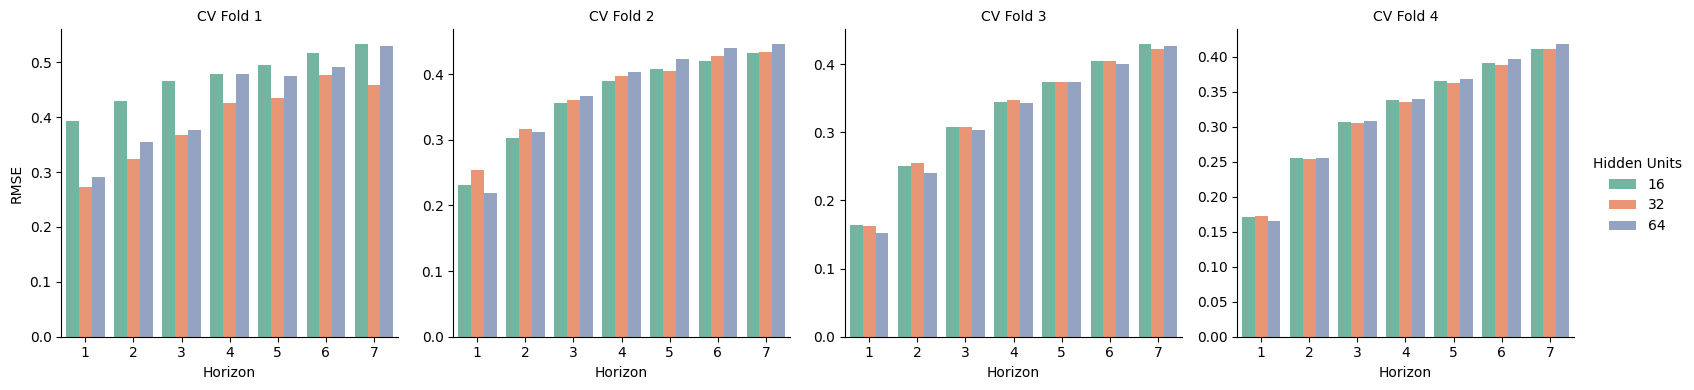

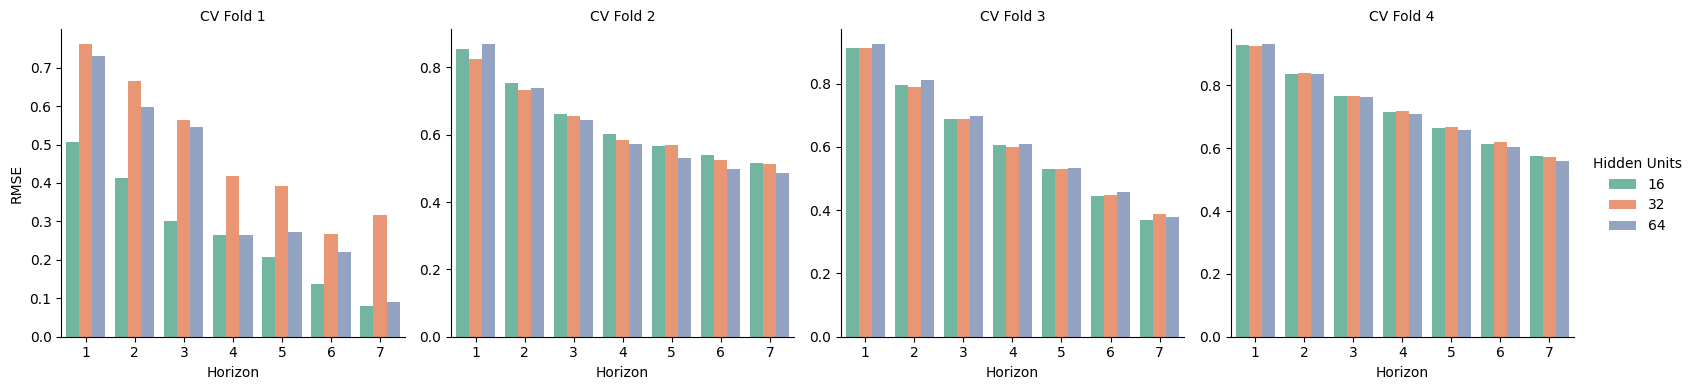

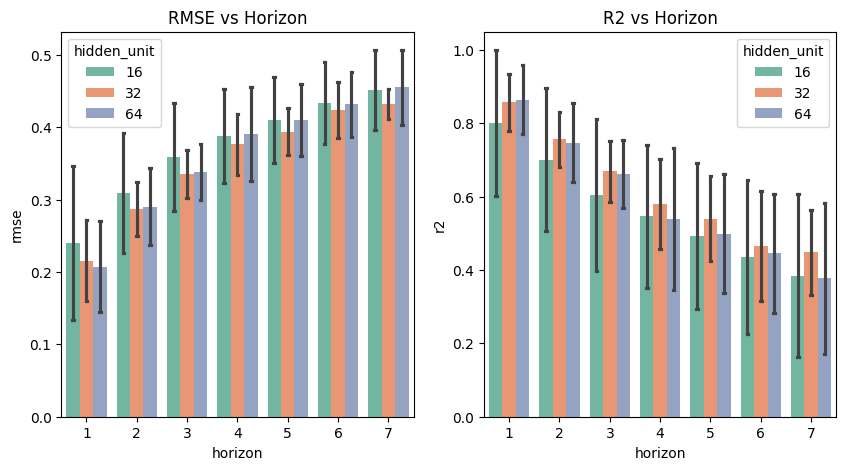

In [ ]:

g = sns.FacetGrid(df_cv_results_horizon, col="cv_fold", col_wrap = 4,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="horizon",
    y="rmse",
    hue = 'hidden_unit',
    palette = "Set2",
    legend = True,
)
g.add_legend(title='Hidden Units')
g.set_axis_labels("Horizon", "RMSE")
g.set_titles(col_template="CV Fold {col_name}")


g_r = sns.FacetGrid(df_cv_results_horizon, col="cv_fold", col_wrap = 4,
              height=4, sharey=False).map_dataframe(
    sns.barplot,
    x="horizon",
    y="r2",
    hue = 'hidden_unit',
    palette = "Set2",
    legend = True,
)
g_r.add_legend(title='Hidden Units')
g_r.set_axis_labels("Horizon", "R2")
g_r.set_titles(col_template="CV Fold {col_name}")

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax = sns.barplot(df_cv_results_horizon, x="horizon", y="rmse", hue="hidden_unit", palette = "Set2",
                 ci="sd", capsize=0.1, ax=ax)

ax2 = sns.barplot(df_cv_results_horizon, x="horizon", y="r2", hue="hidden_unit", palette = "Set2",
                 ci="sd", capsize=0.1, ax=ax2)
ax.set_title("RMSE vs Horizon")
ax2.set_title("R2 vs Horizon")


- performance appears more stable when hidden space dimension is 32 

In [24]:
hidden_unit_size = 64

In [25]:
model_at = build_autoregressive_model_lstm(train_X_ts_at, train_day_feat_X_at, train_static_X_ts_at, lag_n,
                                           label_window_size = label_window_size, hidden_unit = hidden_unit_size)
history_at = model_at.fit(
    train_ds_at,
    epochs=100,
    validation_data=val_ds_at,
)


Epoch 1/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.4152 - mae: 0.4485 - rmse: 0.6462 - val_loss: 0.2556 - val_mae: 0.2787 - val_rmse: 0.3925
Epoch 2/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2347 - mae: 0.2524 - rmse: 0.3666 - val_loss: 0.2123 - val_mae: 0.2353 - val_rmse: 0.3528
Epoch 3/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2133 - mae: 0.2336 - rmse: 0.3513 - val_loss: 0.1987 - val_mae: 0.2226 - val_rmse: 0.3424
Epoch 4/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2033 - mae: 0.2256 - rmse: 0.3449 - val_loss: 0.1907 - val_mae: 0.2158 - val_rmse: 0.3358
Epoch 5/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1970 - mae: 0.2205 - rmse: 0.3396 - val_loss: 0.1879 - val_mae: 0.2136 - val_rmse: 0.3347
Epoch 6/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1916 - mae: 0.2165 - rmse: 0.3364 - val_loss: 0.1789 - val_mae: 0.2068 - val_rmse: 0.3252
Epoch 7/100
118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1859 - mae: 0.2124 

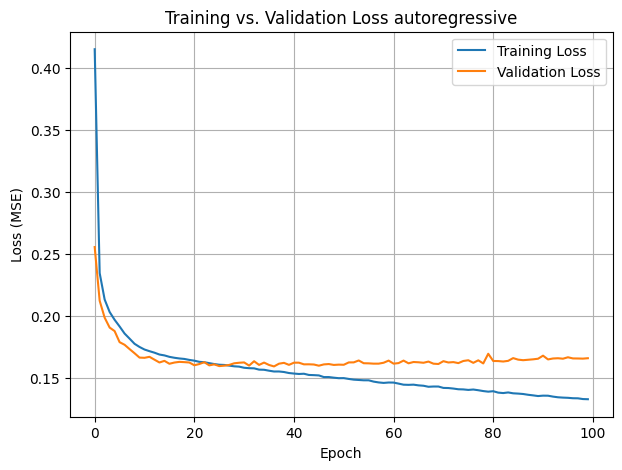

In [26]:


# Extract loss values
train_loss_at= history_at.history["loss"]
val_loss_at = history_at.history["val_loss"]

# Plot
plt.figure(figsize=(7, 5))
plt.plot(train_loss_at, label="Training Loss")
plt.plot(val_loss_at, label="Validation Loss")
plt.title("Training vs. Validation Loss autoregressive")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()




# y_pred_val_1day_at= model_at.predict(val_ds_at)# show first few predictions

# rmse_1day_at = root_mean_squared_error(clip_and_inverse_log2_transform(y_pred_val_1day_at), clip_and_inverse_log2_transform(val_y_at))
# r2_1day_at = r2_score(clip_and_inverse_log2_transform(val_y_at), clip_and_inverse_log2_transform(y_pred_val_1day_at))
# print(f'rmse: {rmse_1day_at:3f}, r2: {r2_1day_at:3f} ')
# plt.scatter(clip_and_inverse_log2_transform(val_y_at), clip_and_inverse_log2_transform(y_pred_val_1day_at))

In [27]:
#sanity check on the newly built function with ridge regression, the prediction is the same from the other function
y_pred_val_horizon= model_at.predict(val_ds_at)

y_val_horizon = []
for _, y_batch in val_ds_at:
     y_val_horizon.append(y_batch.numpy())
y_val_horizon = np.concatenate(y_val_horizon, axis=0)

        # compute rmse and r2 along the trajectory
rmses_val_horizon = [root_mean_squared_error(y_val_horizon[:, i],y_pred_val_horizon[:, i]) for i in range(0, y_val_horizon.shape[1])]
r2s_val_horizon = [r2_score(y_val_horizon[:, i],y_pred_val_horizon[:, i]) for i in range(0, y_val_horizon.shape[1])]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [30]:
y_val_horizon[:, 6]

array([0.9358731, 0.9368516, 0.9460076, ..., 0.       , 0.       ,
       0.       ], shape=(3140,), dtype=float32)

In [31]:
r2_at = r2_score(clip_and_inverse_log2_transform(y_val_horizon[:, 6]), clip_and_inverse_log2_transform(y_pred_val_horizon[:, 6]))
rmse_at = root_mean_squared_error(clip_and_inverse_log2_transform(y_val_horizon[:, 6]), clip_and_inverse_log2_transform(y_pred_val_horizon[:, 6]))

print(f"r2: {r2_at}\n rmse: {rmse_at}")

r2: 0.5074546337127686
 rmse: 0.5541832447052002
